# Demo: A Simple Neural Network Example

In this demo, you will learn:
* How to construct and train a simple neural network with one hidden layer using the `pytorch` package
* How to get the weights and intermediate layer outputs of a `pytorch` network after training
* How to visualize the weights 

To illustrate the concepts, we consider a simple 2D classification problem on completely synthetic data. Using synthetic data will allow us to visualize the network more easily.  We will then look at real data in later demos  

## Loading Pytorch

The `pytorch` package provides a powerful and simple platform for building and fitting neural networks.  To run `pytorch`, you wil need to install pytorch. If you have anaconda, use the following command to install Pytorch into your current environment:

    conda install pytorch-cpu torchvision-cpu -c pytorch
    
or if you are on mac:

    conda install pytorch torchvision -c pytorch

If you do not have anaconda, or would like to install with GPU support, or have any other spefollow the instuctions at https://pytorch.org/get-started/locally/.
    
You should then be able to load the package.

In [1]:
import torch

We will also load some other common packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1) # let's reset the random seed for repeatability

## Synthetic Data 

To illustrate the neural network, we generate two-dimensional data with labels mostly = 1 in a circular region and labels mostly = 0 outside that region. 

In [3]:
nsamp = 400   # number of samples to generate
nx = 2        # number of dimensions of each sample

# The features are generated uniformly on the square [0,1] x [0,1]
X = np.random.uniform(0,1,(nsamp,nx))

# The labels are more likely to be 1 when the feature radius is small.  
# The particular design of this function is not important.
rsq = (X[:,0]-0.5)**2 + (X[:,1]-0.5)**2
z = 10*(np.exp(-8*rsq)-0.5)
py = 1/(1+np.exp(-z))
u = np.random.uniform(0,1,nsamp)
y = (u < py).astype(int)

We create a scatter plot of the data.  You can see that it is not linearly seperable.  

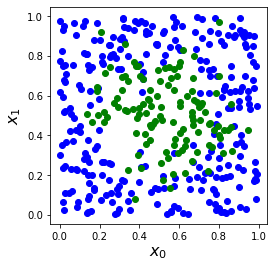

In [4]:
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')
plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
plt.axis('square');
#plt.subplots_adjust(bottom=0.2, left=0.2)

## Create a Pytorch dataset and dataloader
A dataset is a pytorch object that contains your training dataset. Here we will use the `TensorDataset` function to create a dataset from a tensor, but you can also create datasets from folders or use preconfigured datasets for many popular machine learning tasks.

A `dataloader` is an object that loads the data from the dataset into your model. We will be using a batch size of 100. More details on the dataloader will be given below.


In [5]:
import torch.utils.data

# Convert the numpy arrays to tensors
X_torch = torch.Tensor(X)
y_torch = torch.Tensor(y)

# Create a Dataset from the tensors
dataset = torch.utils.data.TensorDataset(X_torch, y_torch)
# Creates a data loader from dataset
loader = torch.utils.data.DataLoader(dataset,batch_size=100) 


## Creating a Simple Neural Network

`torch.nn` contains all the basic building blocks to build your neural network

Building a Neural Network in Pytorch is as simple as defining a class with two methods: `__init__` and `forward`.

1. `__init__`

This method initiates the model. First we initiate the network as an `nn.Module`. Then we add the layers and other necessary components. `nn.Linear(chan_in, chan_out)` creates a linear (also called fully-connected, or dense) layer with `chan_in` input channels and `chan_out` output channels. This first layer will have `chan_in=nin`, the number of inputs to the network, and `chan_out=nh`, the number of hidden nodes. The second layer, which is also our final or output layer, will have `chan_in=nh` inputs, which are the outputs of the previous layer, and `chan_out=nout` outputs, which is the number of outputs of the network. `nn.Sigmoid` creates a sigmoid activation function.


2. `forward`

This is the method that is called when you pass data through the network. The first dense layer is implemented and its output is passed through the activation function. The result is then passed through the second dense layer and the activation function again.

Finally, we instantiate our network class by calling `Net()`. Our network will have `nin=2` inputs, since our input is in 2D, `nh=4` hidden units (this is a design parameter; we could try other values here), and `nout=1` outputs, corresponding to the estimated class label.

In [6]:
import torch.nn as nn

nh = 4

# nin: dimension of input data
# nh: number of hidden units
# nout: number of outputs = 1 since this is binary classification

class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.activation = nn.Sigmoid()
        self.Dense1 = nn.Linear(nin,nh)
        self.Dense2 = nn.Linear(nh,nout)
        
    def forward(self,x):
        x = self.activation(self.Dense1(x))
        out = self.activation(self.Dense2(x))
        return out

model = Net(nin=nx,nh=nh,nout=1)

We can print a summary of our network using `print(str(model))`.

In [7]:
print(str(model))

Net(
  (activation): Sigmoid()
  (Dense1): Linear(in_features=2, out_features=4, bias=True)
  (Dense2): Linear(in_features=4, out_features=1, bias=True)
)


## Training the Network

To train the network, we have to select an optimizer and a loss function.  Since this is a binary classification problem, we select the binary cross-entropy loss, which is implemented as `nn.BCELoss`.  For the optimizer, we select `optim.Adam` since it tends to work well over a wide range of problems.

`optim.Adam(model.parameters(), lr=0.01)` intantiates an optimizer that is linked to the parameters of our model. It also sets the learning rate to 0.01. The learning rate is a tunable parameter. Setting it between $10^{-2}$ and $10^{-4}$ is often a good place to start, but often this parameter requires further tuning.

`nn.BCELoss()` creates a function that we will call later to compute the loss

In [8]:
import torch.optim as optim

opt = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

Now it's time to actually train the network.
We will iterate over the training data `num_epoch` times. Iterating over the data is performed using an enumerator constructed from the dataloader object, `loader`. During each inner-loop iteration, one mini-batch of training data is processed.

Important things to note here:

`x_batch` has dimensions `(batch_size, 2)` since the training is two-dimensional

`y_batch` has dimensions `(batch_size,1)` since the labels are scalars

`out = model(x_batch)` Performs a forward pass through the network (using the forward function we defined above). The output is of size `(batch_size, 1)` and corresponds to the probability of class 1, estimated by the network, for every feature vector value in the minibatch.

`loss = criterion(out,y_batch)` Computes the loss by comparing the output to the true values

`opt.zero_grad()` Initialize the gradient values at zero (the gradients of the model parameters)

`loss.backward()` Performs backpropagation to compute the loss gradient wrt each model parameter. If we didn't zero the gradient values, this would add the gradient to the previous value.

`opt.step()` The optimizer takes a 'step' using the current gradient values.

In [9]:
num_epoch = 2000

print_intvl = 100
avg_loss = np.zeros([num_epoch])
avg_acc = np.zeros([num_epoch])

# Outer loop over epochs
for epoch in range(num_epoch):
    error = 0 # initialize error counter
    total = 0 # initialize total counter
    batch_loss = []
    # Inner loop over mini-batches
    for batch, data in enumerate(loader):
        x_batch,y_batch = data
        y_batch = y_batch.view(-1,1) # resizes y_batch to (batch_size,1)
        out = model(x_batch)
        # Compute loss
        loss = criterion(out,y_batch)        
        batch_loss.append(loss.item())
        # Compute gradients using back-propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step' (i.e., update parameters)
        opt.step()
        # Do hard decision
        guess = out.round()
        # Compute number of decision errors
        error += torch.sum(torch.abs(guess - y_batch))
        total += len(y_batch)
        
    acc = 100*(1-error/total) # Compute accuracy over epoch
    avg_loss[epoch] = np.mean(batch_loss) # Compute average loss over epoch
    avg_acc[epoch] = acc
    
    # Print details if epoch is multiple of print_intvl
    if (epoch+1) % print_intvl == 0:
        print('Epoch: {0:d}   Loss: {1:e}   Accuracy: {2:.2f}'.format(epoch+1, avg_loss[epoch] ,avg_acc[epoch]))
        

Epoch: 100   Loss: 5.973828e-01   Accuracy: 70.25
Epoch: 200   Loss: 5.598182e-01   Accuracy: 70.25
Epoch: 300   Loss: 5.214323e-01   Accuracy: 70.25
Epoch: 400   Loss: 4.996384e-01   Accuracy: 70.00
Epoch: 500   Loss: 4.411171e-01   Accuracy: 80.75
Epoch: 600   Loss: 3.317699e-01   Accuracy: 87.25
Epoch: 700   Loss: 2.986763e-01   Accuracy: 87.00
Epoch: 800   Loss: 2.880964e-01   Accuracy: 87.75
Epoch: 900   Loss: 2.835942e-01   Accuracy: 88.25
Epoch: 1000   Loss: 2.812108e-01   Accuracy: 88.75
Epoch: 1100   Loss: 2.795672e-01   Accuracy: 89.00
Epoch: 1200   Loss: 2.783249e-01   Accuracy: 88.50
Epoch: 1300   Loss: 2.774289e-01   Accuracy: 88.25
Epoch: 1400   Loss: 2.767600e-01   Accuracy: 88.25
Epoch: 1500   Loss: 2.762161e-01   Accuracy: 88.25
Epoch: 1600   Loss: 2.757333e-01   Accuracy: 88.25
Epoch: 1700   Loss: 2.752764e-01   Accuracy: 88.25
Epoch: 1800   Loss: 2.748294e-01   Accuracy: 88.25
Epoch: 1900   Loss: 2.743896e-01   Accuracy: 88.50
Epoch: 2000   Loss: 2.739602e-01   Accur

We can now plot the loss function and accuracy versus the epoch number.  

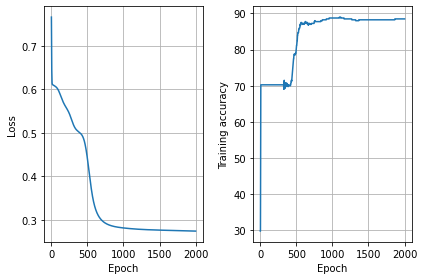

In [10]:
epoch_it = np.arange(1,num_epoch+1)
plt.subplot(1,2,1)
plt.plot(epoch_it, avg_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epoch_it, avg_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.tight_layout()
plt.show()

## Visualizing Decision Regions

To see the classification rule our neural network learned, we can plot the predicted class probability as a function of $x=(x_0,x_1)$.  To do this, we create an input matrix `Xplot` whose rows densely sample all possibilities of $x=(x_0,x_1) \in[0,1] \times [0,1]$.  We feed that into the trained network to see what the probability $P(y=1|x)$ is for each $x$.  Then, we plot this like an image and superimpose the scatter plot from above.

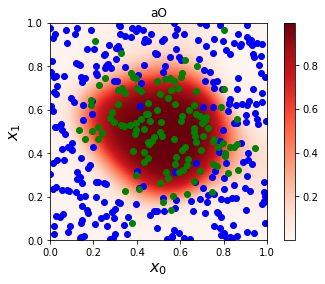

In [17]:
# Limits to plot the response.
xmin = [0,0]
xmax = [1,1]

# Use meshgrid to create the 2D input
nplot = 100
x0plot = np.linspace(xmin[0],xmax[1],nplot)
x1plot = np.linspace(xmin[0],xmax[1],nplot)
x0mat, x1mat = np.meshgrid(x0plot,x1plot)
Xplot = np.column_stack([x0mat.ravel(), x1mat.ravel()])
Xplot_tensor = torch.Tensor(Xplot)

# Compute the output and export to numpy
uOplot = model(Xplot_tensor).detach().numpy()
uOplot_mat = uOplot[:,0].reshape((nplot, nplot))

# Plot the recovered region
plt.imshow(np.flipud(uOplot_mat), extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
plt.colorbar()

# Overlay the samples
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')
plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
plt.title('aO');

## Show hidden node activations
By using `model.activation(model.Dense1(...))` we can access the outputs of the hidden layer. This lets us see what each node in the hidden layer is doing.

We can also access the output layer's weights. This tells us how the hidden outputs are combined to give the output-layer score, which goes into the output-layer activation function.

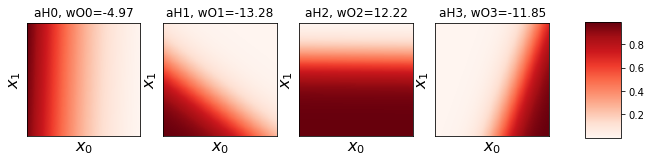

In [12]:
# Get the outputs of the hidden layer 
ahid = model.activation(model.Dense1(Xplot_tensor))
ahid_plot = ahid.detach().numpy()
ahid_plot = ahid_plot.reshape((nplot,nplot,nh))

# Get the weights of the output layer
state_dict = model.state_dict()
Wo, bo = state_dict['Dense2.weight'], state_dict['Dense2.bias']

fig = plt.figure(figsize=(10, 4))

for i in range(nh):
    plt.subplot(1,nh,i+1)
    ahid_ploti = np.flipud(ahid_plot[:,:,i])
    im = plt.imshow(ahid_ploti, extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('$x_0$', fontsize=16)
    plt.ylabel('$x_1$', fontsize=16)
    plt.title('aH{0:d}, wO{0:d}={1:4.2f}'.format(i,Wo[0,i]))
  
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.30, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax);

## Let us print the model parameters. 

One way to access model parameters are throught the model's state dictionary. For example, we can print the entire model weights as

In [13]:
print("Model's state_dict")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])


Model's state_dict
Dense1.weight 	 tensor([[-3.9719,  0.1436],
        [-5.3634, -7.0209],
        [-0.0942, -9.8737],
        [10.3459, -3.6744]])
Dense1.bias 	 tensor([ 0.5990,  4.3353,  6.7219, -6.0054])
Dense2.weight 	 tensor([[ -4.9668, -13.2760,  12.2164, -11.8499]])
Dense2.bias 	 tensor([-1.8209])


Or we can access the individual weights using

In [14]:
Wh, bh = model.state_dict()['Dense1.weight'], model.state_dict()['Dense1.bias']
print('WH=')
print(Wh)
print('bH=')
print(bh)

Wo, bo = model.state_dict()['Dense2.weight'], model.state_dict()['Dense2.bias']
print('wO=')
print(Wo)
print('bO=')
print(bo)

WH=
tensor([[-3.9719,  0.1436],
        [-5.3634, -7.0209],
        [-0.0942, -9.8737],
        [10.3459, -3.6744]])
bH=
tensor([ 0.5990,  4.3353,  6.7219, -6.0054])
wO=
tensor([[ -4.9668, -13.2760,  12.2164, -11.8499]])
bO=
tensor([-1.8209])


## Plot the hidden-layer classifier boundaries

Now that we know the weights, we can use them to compute the hidden-layer classifier boundaries and superimpose them on the scatter plot.

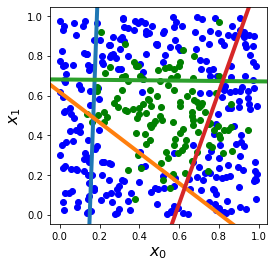

In [15]:
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')
plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
x0min, x0max, x1min, x1max = plt.axis()

x0a = x0min
x0b = x0max
for i in range(nh):
    b = bh[i].detach().numpy()
    w0 = Wh[i,0].detach().numpy()
    w1 = Wh[i,1].detach().numpy()
    x1a = -(b+x0a*w0)/w1
    x1b = -(b+x0b*w0)/w1
    plt.plot([x0a,x0b],[x1a,x1b],linewidth=4)

plt.axis('square')
plt.axis((x0min, x0max, x1min, x1max));